In [1]:
import pycrfsuite

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
from _chain import Chain, f_phi, f_psi
from _chain_torch import Chain as ChainTorch
from _loss import HingeLoss
from _data_utils import ChainDataset, count_parameters

from _chain_bp_loss import belief_propagation_cross_entropy_loss  # remove wheb ready

In [6]:
import plotly.graph_objects as go

In [7]:
import progressbar

### Define Binary HMM 

In [8]:
phi = f_phi(b=[-0.8, 1])
psi = f_psi(j=2.5)

In [9]:
T = 10 # chain length

In [10]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [11]:
possible_values = [0, 1]

In [12]:
N = 1000

In [13]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 1.23 s, sys: 11.4 ms, total: 1.24 s
Wall time: 1.24 s


In [14]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

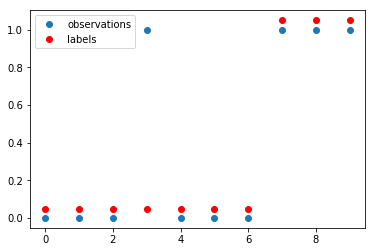

In [15]:
i = np.random.randint(1000)
plot(X_dataset[i], 'o')
plot(y_dataset[i] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train CRF

In [16]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [17]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [18]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [20]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [21]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0,
    c2=0,  # regulate this up to 1 if needed
    max_iterations=5000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 54.5 ms, sys: 3.76 ms, total: 58.3 ms
Wall time: 59.5 ms


CRF(algorithm='lbfgs', all_possible_states=True,
  all_possible_transitions=True, averaging=None, c=None, c1=0, c2=0,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=5000,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [22]:
y_pred = crf.predict(X_test)

In [23]:
labels = list(crf.classes_)
labels

['0', '1']

In [24]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       837
           1      1.000     1.000     1.000      1163

   micro avg      1.000     1.000     1.000      2000
   macro avg      1.000     1.000     1.000      2000
weighted avg      1.000     1.000     1.000      2000



In [25]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
1      -> 1       85.789798
0      -> 0       67.105006
1      -> 0       -75.635257
0      -> 1       -77.259547


In [26]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
55.576508 0        x.current=0
50.700024 1        x.current=1
-50.700024 0        x.current=1
-55.576508 1        x.current=0


###  Training MPNN based model

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Define 

In [644]:
n_epochs = 100
batch_size = 64 # len(X_train) # 256

In [645]:
trainset = ChainDataset(X_train, y_train)
testset = ChainDataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=2)

In [659]:
j = Variable(torch.tensor([-31.]), requires_grad=True)
b = Variable(torch.tensor([-15.5, -15.5]), requires_grad=True)

In [660]:
init_lr = 0.01

In [661]:
optimizer = optim.Adam([j, b], lr=init_lr)

In [662]:
hinge_loss = HingeLoss(margin=1)

In [663]:
model = ChainTorch(length=T)

#### Train

In [664]:
def decay_lr(optimizer, epoch):
    lr = init_lr * (0.5 ** (epoch // 80))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [665]:
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        X_batch, y_batch = Variable(batch['X'], requires_grad=False), Variable(batch['y'], requires_grad=False)
        
        #print('J: {},  b0: {}, b1: {}'.format(j[0], b[0], b[1]))
        
        optimizer.zero_grad()
        beliefs = model(j, b, X_batch)
        loss = hinge_loss(beliefs, y_batch)
        loss.backward()
        
        #b.grad.data[1].fill_(0)  # take b[1] as constant
        #print('JGrad: {},  bGrad: {}'.format(j.grad.data, b.grad.data))
    
        optimizer.step()
     
    decay_lr(optimizer, epoch) 
    
    # evaluation
    if epoch % 1 == 0:
        valid = next(iter(validloader))
        X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
        with torch.no_grad():
            beliefs_valid = model(j, b, X_valid)
            loss_valid = hinge_loss(beliefs_valid, y_valid)

        print('>>>\t epoch {}:: loss = {}, validation loss = {} [b0={}, b1={}, j={}]'. format(
            epoch, loss, loss_valid, b[0], b[1], j[0]))
        learning_curve.append({
            'epoch': epoch + 1,
            'loss': loss,
            'loss_valid': loss_valid,
            'b': [b.data.clone()[0], b.data.clone()[1]],
            'j': j.data.clone()[0],
            'b_grad': [b.grad.data.clone()[0], b.grad.data.clone()[1]],
            'j_grad': j.grad.data.clone()[0]
        })
        

>>>	 epoch 1:: loss = 9.988666534423828, validation loss = 9.911370277404785 [b0=-15.612883567810059, b1=-15.384349822998047, j=-30.928157806396484]
>>>	 epoch 2:: loss = 9.96352481842041, validation loss = 9.888775825500488 [b0=-15.69528865814209, b1=-15.30247974395752, j=-30.8660945892334]
>>>	 epoch 3:: loss = 10.049830436706543, validation loss = 9.877237319946289 [b0=-15.689918518066406, b1=-15.336396217346191, j=-30.815000534057617]
>>>	 epoch 4:: loss = 9.947286605834961, validation loss = 9.870843887329102 [b0=-15.691543579101562, b1=-15.362395286560059, j=-30.76628875732422]
>>>	 epoch 5:: loss = 9.782501220703125, validation loss = 9.868103981018066 [b0=-15.702646255493164, b1=-15.364139556884766, j=-30.73957061767578]
>>>	 epoch 6:: loss = 9.813167572021484, validation loss = 9.867341041564941 [b0=-15.702301025390625, b1=-15.366301536560059, j=-30.736845016479492]
>>>	 epoch 7:: loss = 9.791444778442383, validation loss = 9.867011070251465 [b0=-15.702282905578613, b1=-15.367

>>>	 epoch 57:: loss = 9.837581634521484, validation loss = 9.8698148727417 [b0=-15.6978120803833, b1=-15.37240982055664, j=-30.73202896118164]
>>>	 epoch 58:: loss = 9.7747802734375, validation loss = 9.868758201599121 [b0=-15.695457458496094, b1=-15.365636825561523, j=-30.747699737548828]
>>>	 epoch 59:: loss = 9.85094165802002, validation loss = 9.867551803588867 [b0=-15.70213794708252, b1=-15.365240097045898, j=-30.73572540283203]
>>>	 epoch 60:: loss = 9.855844497680664, validation loss = 9.869011878967285 [b0=-15.703598022460938, b1=-15.361396789550781, j=-30.739355087280273]
>>>	 epoch 61:: loss = 9.864616394042969, validation loss = 9.867308616638184 [b0=-15.699106216430664, b1=-15.366934776306152, j=-30.738628387451172]
>>>	 epoch 62:: loss = 9.994483947753906, validation loss = 9.867661476135254 [b0=-15.703261375427246, b1=-15.367753028869629, j=-30.729475021362305]
>>>	 epoch 63:: loss = 9.79897403717041, validation loss = 9.870454788208008 [b0=-15.696805953979492, b1=-15.35

In [ ]:
plot([(v['loss'], v['loss_valid']) for v in learning_curve]);
title('Loss learning curve');
legend(['Loss', 'Validation Loss']);

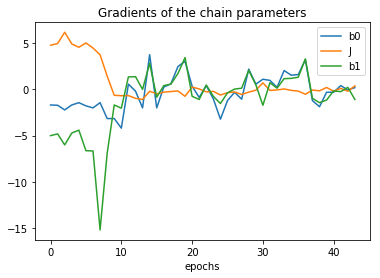

In [427]:
plot([(v['b_grad'][0], v['j_grad'],  v['b_grad'][1]) for v in learning_curve]);
title('Gradients of the chain parameters')
xlabel('epochs')
legend(['b0', 'J', 'b1'])

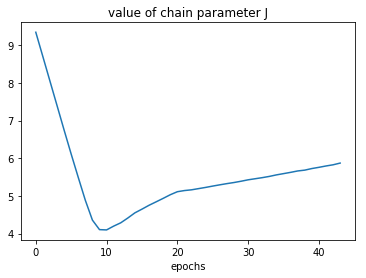

In [428]:
plot([v['j'] for v in learning_curve]);
title('value of chain parameter J');
xlabel('epochs');

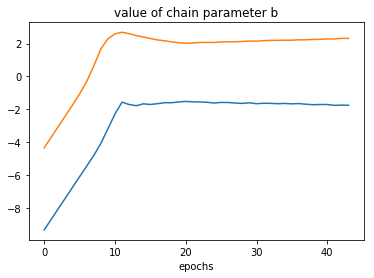

In [429]:
plot([v['b'] for v in learning_curve]);
title('value of chain parameter b');
xlabel('epochs');

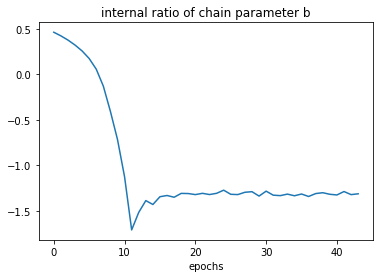

In [430]:
plot([v['b'][1] / v['b'][0] for v in learning_curve]);
title('internal ratio of chain parameter b');
xlabel('epochs');

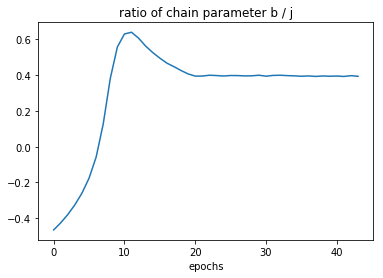

In [431]:
plot([v['b'][1] / v['j'] for v in learning_curve]);
title('ratio of chain parameter b / j');
xlabel('epochs');

### Evaluate 

In [395]:
valid = next(iter(validloader))
X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
with torch.no_grad():
    beliefs_pred = model(j, b, X_valid)
    
    y_pred = (beliefs_pred[:, 1, :] > beliefs_pred[:, 0, :])\
    .float()\
    .detach()\
    .numpy()

In [405]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_valid.detach().numpy() for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00      1250

   micro avg       1.00      1.00      1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



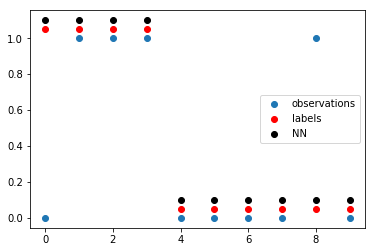

In [407]:
i = np.random.randint(200)
plot(X_valid.detach().numpy()[i], 'o')
plot(y_valid.detach().numpy()[i] + 0.05, 'ro')
plot(y_pred[i] + 0.1, 'ko')
legend(['observations', 'labels', 'NN'])

### Sanity - check that we can reach loss zero

In [244]:
ind = np.random.randint(1000)
j = [2.5] 
b = [-0.8, 1.]
labels = y_dataset[ind]
observations = X_dataset[ind]

In [245]:
labels.shape, observations.shape

((2,), (2,))

In [246]:
# add batch dimension

In [247]:
labels = np.expand_dims(labels, axis=0)
observations = np.expand_dims(observations, axis=0)

In [248]:
# move to tensors

In [249]:
j = torch.Tensor(j)
b = torch.Tensor(b)
labels = torch.Tensor(labels)
observations = torch.Tensor(observations)

In [250]:
%%time
beliefs = model(j, b, observations)
loss = hinge_loss(beliefs, labels)

CPU times: user 114 ms, sys: 323 ms, total: 437 ms
Wall time: 709 ms


In [251]:
pred_labels = (beliefs[:, 1, :] > beliefs[:, 0, :]).float()

In [252]:
loss, torch.eq(labels, pred_labels), torch.all(torch.eq(labels, pred_labels))

(tensor(1.6000),
 tensor([[1, 1]], dtype=torch.uint8),
 tensor(1, dtype=torch.uint8))

In [253]:
labels

tensor([[1., 1.]])

In [254]:
pred_labels

tensor([[1., 1.]])

###  Plot the loss function

####  target loss

In [55]:
j = [2.5]
b = [-0.8, 1.]

len_ = len(X_train[:10])

j = torch.Tensor(j) 
b = torch.Tensor(b)

observations = torch.Tensor(X_train[:10])
labels = torch.Tensor(y_train[:10])

beliefs = model(j, b, observations)
target_loss = hinge_loss(beliefs, labels)

pred_labels = ((beliefs[:, 1, :] > beliefs[:, 0, :])).float()

target_loss, int(torch.all(torch.eq(labels, pred_labels.float())))

(tensor(8.3450), 1)

#### Plot loss surface

In [49]:
bar = progressbar.ProgressBar(maxval=3000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [ ]:
res = {'b0': [], 'b1': [], 'j': [], 'loss': [], 'zero_one_loss': []}

bar.start()
for i_sample in range(3000):
    bar.update(i_sample + 1)
    j_val = 2.5 + 5 * (np.random.rand() - 0.5)
    b_base = [2 * (np.random.rand() - 0.5) , 1]
  
    j = torch.Tensor([j_val])
    b = torch.Tensor(b_base)
    
    labels = torch.Tensor(y_train[:10])
    observations = torch.Tensor(X_train[:10])
    
    res['b0'].append(b_base[0])
    res['b1'].append(b_base[1])
    res['j'].append(j_val)
    
    beliefs = model(j, b, observations)
    res['loss'].append(hinge_loss(beliefs, labels))
    
    pred_labels = (beliefs > 0.5).float()
    res['zero_one_loss'].append(int(torch.all(torch.eq(labels, pred_labels))))
    
bar.finish()

In [366]:
df = pd.DataFrame(res)

In [367]:
df.zero_one_loss.value_counts()

0    3000
Name: zero_one_loss, dtype: int64

In [370]:
trace = go.Scatter3d(
        x=df['b0'],
        y=df['j'], 
        z=df['loss'], 
        mode='markers',
        marker=dict(
            size=10,
            color=df['zero_one_loss'],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        ),
)

data = [trace]

scene = go.layout.Scene(
        annotations=[
            dict(
                x=-.8,
                y=2.5,
                z=target_loss,
                text="target",
                textangle=0,
                ax=0,
                ay=-75,
                font=dict(
                    color="red",
                    size=18
                ),
                arrowcolor="red",
                arrowsize=3,
                arrowwidth=1,
                arrowhead=1
        )],
)

fig = go.Figure()
fig.add_trace(trace)
fig.update_layout(scene=scene)
fig.write_html('loss_vs_data_term.html', auto_open=True)

### Plot 1D travel  

In [35]:
def show_1d_travel(direction, labels, observations, N=1000, scale=1):
    direction = np.array(direction)
    
    bar = progressbar.ProgressBar(maxval=N, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    z = np.zeros((N,))
    alpha = np.zeros((N,))

    p0 = -direction
    p1 = direction

    bar.start()
    for i in range(N):
        bar.update((i  + 1))
        alpha[i] = np.random.rand()

        p = (1 - alpha[i]) * p0 + alpha[i] * p1
        p = p * scale

        b = torch.Tensor([p[0], p[1]])
        j = torch.Tensor([p[2]])

        beliefs = model(j, b, observations)
        z[i] = hinge_loss(beliefs, labels).item()


    bar.finish()

    x_t = alpha[np.argsort(alpha)]
    z_t = z[np.argsort(alpha)]

    fig = go.Figure(data=go.Scatter(x=x_t, y=z_t))

    fig.update_layout(title='Loss Surface [1D] over true direction')
    fig.show()

In [34]:
def show_1d_travel(direction, labels, observations, N=1000, scale=1):
    direction = np.array(direction)
    
    bar = progressbar.ProgressBar(maxval=N, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    z = np.zeros((N,))
    alpha = np.zeros((N,))
    
    p0 = np.array([0, 0, 0])
    p1 = np.array([direction[0], direction[1], direction[2]])

    bar.start()
    for i in range(N):
        bar.update((i  + 1))
        alpha[i] = np.random.rand()

        p = (1 - alpha[i]) * p0 + alpha[i] * p1
        p = p * scale

        b = torch.Tensor([p[0], p[1]])
        j = torch.Tensor([p[2]])

        beliefs = model(j, b, observations)
        z[i] = hinge_loss(beliefs, labels).item()
        
        ####
        ## analytical gradient
        ####
        zero = torch.Tensor([0])
        beliefs_margin = (beliefs[:, 1, :] - beliefs[:, 0, :])
        labels_sign = (labels - 0.5) * 2   # turn 0, 1 to -1, 1
        
        is_below_margin = 1 * (1 > torch.mul(beliefs_margin, labels_sign))
        is_x_negative = 1 * (observations == 0)
        is_x_positive = 1 * (observations == 1)
        is_relevant_A = 1 * torch.mul(is_x_negative, is_below_margin)
        is_relevant_B = 1 * torch.mul(is_x_positive, is_below_margin)

        pred_labels = (beliefs[:, 1, :] > beliefs[:, 0, :]).float()
        pred_labels_right = torch.roll(pred_labels, 1)
        pred_labels_right[0, 0] = 0
        pred_labels_left = torch.roll(pred_labels, -1)
        pred_labels_left[0, -1] = 0
        
        der_A = -2 * torch.sum(torch.mul(is_relevant_A.float(), labels_sign))
        der_B = -2 * torch.sum(torch.mul(is_relevant_B.float(), labels_sign))
        der_C = 2 * torch.sum(pred_labels_right + pred_labels_left)
        
        grad = abs(der_A) + abs(der_B) + abs(der_C)

        #z[i] = max(0, (1 - torch.mul(beliefs_margin, labels_sign))[0, 1])
        ###

    bar.finish()

    x_t = alpha[np.argsort(alpha)]
    z_t = z[np.argsort(alpha)]

    fig = go.Figure(data=go.Scatter(x=x_t, y=z_t))

    fig.update_layout(title='Loss Surface [1D] over true direction')
    fig.show()

#### In the "True" direction

In [35]:
def show_1d_travel_constant_radius(direction, labels, observations, N=1000, scale=1):
    direction = np.array(direction)
    
    bar = progressbar.ProgressBar(maxval=N, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    z = np.zeros((N,))
    alpha = np.zeros((N,))

    p0 = direction

    bar.start()
    for i in range(N):
        bar.update((i  + 1))
        alpha[i] = np.random.rand()

        theta = np.deg2rad(360 * alpha[i])
        M0 = rotation_matrix(axis, theta)
        p = dot(M0, direction) * scale

        b = torch.Tensor([p[0], p[1]])
        j = torch.Tensor([p[2]])

        beliefs = model(j, b, observations)
        z[i] = hinge_loss(beliefs, labels).item()

    bar.finish()

    x_t = alpha[np.argsort(alpha)]
    z_t = z[np.argsort(alpha)]

    fig = go.Figure(data=go.Scatter(x=x_t, y=z_t))

    fig.update_layout(title='Loss Surface [1D] over true direction')
    fig.show()

In [623]:
direction=[-10, -10, -20]#[-8, 10, 25]
axis=[1, 1, -1] #[-45,  24, -24]


theta = np.deg2rad(.1)

M = lambda theta: rotation_matrix(axis, theta)

M0 = rotation_matrix(axis, theta)
p0 = dot(M0, direction)

In [624]:
show_1d_travel(
    direction=p0,
    labels = torch.Tensor(y_train[:1]), 
    observations = torch.Tensor(X_train[:1]),
    scale=1)

[========================================================================] 100%


In [622]:
show_1d_travel_constant_radius(
    direction=[12, 8, -20], 
    labels = torch.Tensor(y_train[:10]), 
    observations = torch.Tensor(X_train[:10]),
    scale=1)

[========================================================================] 100%


In [455]:
show_1d_travel(
    direction=[-6.58, -6.24, -12.49], 
    labels = torch.Tensor(y_train[:10]), 
    observations = torch.Tensor(X_train[:10]),
    scale=5)

[========================================================================] 100%


#### In the perpendicular plane to "True" direction

In [136]:
show_1d_travel(
    direction=[-5, 7, -6],#[-45,  24, -24],
    labels = torch.Tensor(y_train[:10]), 
    observations = torch.Tensor(X_train[:10]),
    scale=1)

[========================================================================] 100%


### Plot 2D travel between dominanat directions

In [556]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def rotation_matrix(axis, theta):
    return expm(cross(eye(3), axis / norm(axis) * theta))

In [557]:
colorscale=[
    [0, "rgb(166,206,227)"],
    [0.01, "rgb(251,154,153)"],
    [1, "rgb(227,26,28)"]
]

In [558]:
def plot_2d_travel_between_directions(direction, axis, labels, observations, origin=[0, 0, 0], degree_span=45, N=30, scale=2):
    
    direction, axis, origin = np.array(direction), np.array(axis), np.array(origin)
    theta = np.radians(degree_span)
    
    M0 = rotation_matrix(axis, -theta)
    M1 = rotation_matrix(axis, theta)
    
    p0 = dot(M0, direction)
    p1 = dot(M1, direction)
    
    bar = progressbar.ProgressBar(maxval=N**2, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    z = np.zeros((N, N))
    alpha = np.zeros((N,))
    beta = np.zeros((N,))

    for i in range(N):
        alpha[i] = scale * np.random.rand()
        beta[i] = scale * np.random.rand()

    bar.start()
    for i in range(N):
        for k in range(N):
            bar.update((i  + 1) * (k + 1))

            p = origin + alpha[i] * p0 + beta[k] * p1
            b = torch.Tensor([p[0], p[1]])
            j = torch.Tensor([p[2]])

            beliefs = model(j, b, observations)
            z[i, k] = hinge_loss(beliefs, labels).item()

    bar.finish()
    
    x_t = alpha[np.argsort(alpha)]
    y_t = beta[np.argsort(beta)]

    z_t = z[np.argsort(alpha), :]
    z_t = z_t[:, np.argsort(beta)]
    
    fig = go.Figure(data=[go.Surface(x=y_t, y=x_t, z=z_t, colorscale=colorscale)])
    fig.update_traces(
        contours_z=dict(
            show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
    fig.update_layout(title='Loss Surface')
    fig.show()

#### Around "True" direction  

In [594]:
plot_2d_travel_between_directions(
    #origin=[-0.8, 1.0, 2.5],
    direction=[-10, -10, -20],#[-8, 10, 25], 
    axis=[1, 1, -1],#[-45,  24, -24], 
    labels= torch.Tensor(y_train[:10]), 
    observations=torch.Tensor(X_train[:10]),
    N=30)

[========================================================================] 100%


In [258]:
plot_2d_travel_between_directions(
    #origin=[-0.8, 1.0, 2.5],
    direction=[10, 10, -20],#[-8, 10, 25], 
    axis=[1, 1, 1],#[-45,  24, -24], 
    labels= torch.Tensor(y_train[:10]), 
    observations=torch.Tensor(X_train[:10]),
    N=30)

[========================================================================] 100%


### Plot 2D travel in Polar coordinates

In [43]:
def plot_2d_travel_polar(direction, axis, labels, observations, N=30, scale=1, log_scale=True, contour_only=False):
    
    direction, axis = np.array(direction), np.array(axis)
    M = lambda theta: rotation_matrix(axis, theta)
    calc_theta = lambda x, y: np.deg2rad((np.rad2deg(np.arctan(y / x)) + 180 * (np.sign(x) < 0) + 360 * (np.sign(y) < 0)) % 360)
    
    bar = progressbar.ProgressBar(maxval=N**2, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    z = np.zeros((N, N))
    theta = np.zeros((N,))
    radius = np.zeros((N,))
    x_cart = np.zeros((N,))
    y_cart = np.zeros((N,))

    for i in range(N):      
        x_cart[i] = scale * (np.random.rand() - 0.5)
        y_cart[i] = scale * (np.random.rand() - 0.5)

    bar.start()
    for i in range(N):
        for k in range(N):
            bar.update((i  + 1) * (k + 1))

            radius = np.linalg.norm([x_cart[i], y_cart[k]], ord=2)
            theta = calc_theta(x_cart[i], y_cart[k])
 
            p = dot(M(theta), direction) * radius
            b = torch.Tensor([p[0], p[1]])
            j = torch.Tensor([p[2]])

            beliefs = model(j, b, observations)
            z[i, k] = hinge_loss(beliefs, labels).item()
            if log_scale:
                z[i, k] = np.log(z[i, k])

    bar.finish()
    
    x_t = x_cart[np.argsort(x_cart)]
    y_t = y_cart[np.argsort(y_cart)]

    z_t = z[np.argsort(x_cart), :]
    z_t = z_t[:, np.argsort(y_cart)]
    
    if contour_only:
        fig = go.Figure(data=[go.Contour(x=y_t, y=x_t, z=z_t)])
    else:
        fig = go.Figure(data=[go.Surface(x=y_t, y=x_t, z=z_t)])
        fig.update_traces(
            contours_z=dict(
                show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
    fig.update_layout(title='Loss Surface')
    fig.show()

In [110]:
def plot_2d_travel_polar_only_one_belief(direction, axis, labels, observations, N=30, scale=1, log_scale=True, contour_only=False, ind_s=0, ind_e=0):
    
    direction, axis = np.array(direction), np.array(axis)
    M = lambda theta: rotation_matrix(axis, theta)
    calc_theta = lambda x, y: np.deg2rad((np.rad2deg(np.arctan(y / x)) + 180 * (np.sign(x) < 0) + 360 * (np.sign(y) < 0)) % 360)
    
    bar = progressbar.ProgressBar(maxval=N**2, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    z = np.zeros((N, N))
    theta = np.zeros((N,))
    radius = np.zeros((N,))
    x_cart = np.zeros((N,))
    y_cart = np.zeros((N,))

    for i in range(N):      
        x_cart[i] = scale * (np.random.rand() - 0.5)
        y_cart[i] = scale * (np.random.rand() - 0.5)

    bar.start()
    for i in range(N):
        for k in range(N):
            bar.update((i  + 1) * (k + 1))

            radius = np.linalg.norm([x_cart[i], y_cart[k]], ord=2)
            theta = calc_theta(x_cart[i], y_cart[k])
 
            p = dot(M(theta), direction) * radius
            b = torch.Tensor([p[0], p[1]])
            j = torch.Tensor([p[2]])

            beliefs = model(j, b, observations)
            z[i, k] = hinge_loss(beliefs[:, :, ind_s:ind_e+1], labels[:, ind_s:ind_e+1]).item()
            if log_scale:
                z[i, k] = np.log(z[i, k])

    bar.finish()
    
    x_t = x_cart[np.argsort(x_cart)]
    y_t = y_cart[np.argsort(y_cart)]

    z_t = z[np.argsort(x_cart), :]
    z_t = z_t[:, np.argsort(y_cart)]
    
    if contour_only:
        fig = go.Figure(data=[go.Contour(x=y_t, y=x_t, z=z_t)])
    else:
        fig = go.Figure(data=[go.Surface(x=y_t, y=x_t, z=z_t)])
        fig.update_traces(
            contours_z=dict(
                show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
    fig.update_layout(title='Loss Surface')
    fig.show()

#### Around (0, 0, 0) rotating in the plane of the "True" direction 

In [178]:
plot_2d_travel_polar_only_one_belief(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[0:1]), 
    observations = torch.Tensor(X_train[0:1]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1,
    ind_s=0,
    ind_e=0)

[========================================================================] 100%


In [141]:
plot_2d_travel_polar_only_one_belief(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[1:2]), 
    observations = torch.Tensor(X_train[1:2]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1,
    ind_s=0,
    ind_e=1)

[========================================================================] 100%


In [115]:
plot_2d_travel_polar_only_one_belief(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[1:2]), 
    observations = torch.Tensor(X_train[1:2]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1,
    ind_s=0,
    ind_e=2)

[========================================================================] 100%


In [ ]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[:100]), 
    observations = torch.Tensor(X_train[:100]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1)

In [206]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[:100]), 
    observations = torch.Tensor(X_train[:100]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1)

[========================================================================] 100%


In [95]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[2:3]), 
    observations = torch.Tensor(X_train[2:3]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1)

[========================================================================] 100%


In [484]:
plot_2d_travel_polar(
    direction=[-6.58, -6.24, -12.49], 
    axis=[1, 1, -1],
    labels = torch.Tensor(y_train[:10]), 
    observations = torch.Tensor(X_train[:10]),
    N=30,
    log_scale=False,
    contour_only=False,
    scale=1)

[========================================================================] 100%


In [148]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train[:10]), 
    observations = torch.Tensor(X_train[:10]),
    N=50,
    scale=5,
    contour_only=True)

[========================================================================] 100%


##  Non-Realizable case

### create a tree factor graph to generate the data

In [62]:
from fglib import graphs, nodes, inference, rv

In [258]:
def create_tree(observations, T=50, chain=False):
    # Create factor graph
    fg = graphs.FactorGraph()

    # Create variable nodes
    x_vec = [nodes.VNode(f'x{i}', rv.Discrete, observed=True) for i in range(T)]
    y_vec = [nodes.VNode(f'y{i}', rv.Discrete) for i in range(T)]

    dist_x0 = torch.Tensor([[1.49, 0.67]])  # parameters to match the original chain parameters
    dist_x1 = torch.Tensor([[0.61, 1.65]])

    # Create factor nodes (with joint distributions)
    f_obs = []
    for i, x, y in zip(range(T), x_vec, y_vec):
        
        dist_obs = dist_x0 if observations[i] == 0 else dist_x1
        f_obs.append(
            nodes.FNode(f'e_obs_{i}', rv.Discrete(dist_obs, x, y)))

    dist_interaction = torch.Tensor([[1.87, 0.54], [0.54, 1.87]])  # parameters to match the original chain parameters
    f_inter = []
    for i in range(T-1):
        f_inter.append(
            nodes.FNode(f'e_inter_{i}', rv.Discrete(dist_interaction, y_vec[i], y_vec[i + 1])))

    fg.set_nodes(x_vec + y_vec)
    fg.set_nodes(f_obs + f_inter)

    # Add edges to factor graph
    for i in range(T):
        fg.set_edge(x_vec[i], f_obs[i])
        fg.set_edge(f_obs[i], y_vec[i])

    # first create chain-like structure
    for i in range(T-1):
        fg.set_edge(y_vec[i], f_inter[i])
        fg.set_edge(f_inter[i], y_vec[i + 1])    

    if not chain:
        # then break the chain into a tree of one split
        break_point = int(3 * T / 4)  # removing end 1/4 of the chain
        fg.remove_edge(y_vec[break_point - 1], f_inter[break_point - 1])
        fg.remove_edge(f_inter[break_point - 1], y_vec[break_point])
        fg.remove_node(f_inter[break_point - 1])

        # now connect the last part to middle of chain to create tree
        dist_interaction = torch.Tensor([[0, 0], [0, 0]])  ### JUST CUTS PART OF THE CHAIN (TEMP)
        attach_point = int(T / 2)
        connection = nodes.FNode(f'e_inter_conn', rv.Discrete(dist_interaction, y_vec[attach_point], y_vec[break_point]))
        fg.set_nodes([connection])

        fg.set_edge(y_vec[attach_point], connection)
        fg.set_edge(connection, y_vec[break_point])
    
    return fg, y_vec

In [52]:
T = 50

In [53]:
N = 1000

In [261]:
%%time 

X_dataset_tree = []
y_dataset_tree = []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    fg, y_nodes = create_tree(x_binary, T=T)
    _, track = inference.max_product(fg) # change to max-sum once back-tracking bug is solved.
    
    y = [track[_y].item() for _y in y_nodes]
    
    X_dataset_tree.append(x_binary)
    y_dataset_tree.append(y)

/Users/shaharazulay/.local/lib/python3.6/site-packages/fglib-0.3.0-py3.6.egg/fglib/rv.py:312: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 19 s, sys: 95.3 ms, total: 19.1 s
Wall time: 19 s


In [262]:
# turn to numpy arrays
X_dataset_tree = np.array([np.array(xi) for xi in X_dataset_tree])
y_dataset_tree = np.array([np.array(yi) for yi in y_dataset_tree])

In [263]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_dataset_tree, y_dataset_tree, test_size=0.2)

### Non-realizable case where the labels are created from a mix of two chains

In [191]:
chainA = Chain(length=T, phi=f_phi(b=[-0.8, 1]), psi=f_psi(j=2.5), possible_values=[0, 1])

chainB = Chain(length=T, phi=f_phi(b=[0.8, -1]), psi=f_psi(j=-2.5), possible_values=[0, 1])

chainC = Chain(length=T, phi=f_phi(b=[-0.8, 1]), psi=f_psi(j=-2.5), possible_values=[0, 1])

In [201]:
%%time 

X_dataset_noise = []
y_dataset_noise = []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chainA.update_observed(x_binary)
    chainB.update_observed(x_binary)
    chainC.update_observed(x_binary)
    
    yA = np.array(chainA.get_max_apostriori_beliefs())
    yB = np.array(chainB.get_max_apostriori_beliefs())
    #yC = np.array(chainC.get_max_apostriori_beliefs())

    r = np.random.rand()
    if r < 0.55:
        y = yA
    else:
        y = yB
    
        
#     rand_indx = np.random.choice(range(T), 1)
#     y[rand_indx] = np.array(chainB.get_max_apostriori_beliefs())[rand_indx]
    
    X_dataset_noise.append(np.array(x_binary))
    y_dataset_noise.append(y)

CPU times: user 512 ms, sys: 69.5 ms, total: 581 ms
Wall time: 534 ms


In [202]:
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_dataset_noise, y_dataset_noise, test_size=0.2)

In [203]:
show_1d_travel(
    direction=[-8, 10, 25], 
    labels = torch.Tensor(y_train_noise[:10]), 
    observations = torch.Tensor(X_train_noise[:10]),
    scale=1)

[========================================================================] 100%


In [204]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train_noise[:10]), 
    observations = torch.Tensor(X_train_noise[:10]),
    N=30,
    log_scale=False,
    scale=1)

[========================================================================] 100%


In [200]:
show_1d_travel(
    direction=[-8, 10, 25], 
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=1)

NameError: name 'y_train_tree' is not defined

In [265]:
show_1d_travel(
    direction=[-45,  24, -24],
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=1)

[========================================================================] 100%


In [266]:
show_1d_travel(
    direction=[8, 10, -25], 
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=1)

[========================================================================] 100%


In [249]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=10, 
    N=30,
    log_scale=False,
    contour_only=False)

[========================================================================] 100%


In [239]:
plot_2d_travel_polar(
    direction=[-8, 10, 25], 
    axis=[-45,  24, -24],
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=1, 
    N=30,
    log_scale=True,
    contour_only=True)

[========================================================================] 100%


In [240]:
plot_2d_travel_polar(
    direction=[-45,  24, -24],
    axis=[-8, 10, 25],
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=1, 
    N=30,
    log_scale=True,
    contour_only=True)

[========================================================================] 100%


In [216]:
radius = 10

In [217]:
labels = torch.Tensor(y_train_tree[:10])
observations = torch.Tensor(X_train_tree[:10])

In [218]:
direction=[-8, 10, 25]
axis=[-45,  24, -24]
M = lambda theta: rotation_matrix(axis, theta)

res = []
for theta_deg in range(10, 370, 5):
    theta = np.deg2rad(theta_deg)
    p = dot(M(theta), direction) * radius
    b = torch.Tensor([p[0], p[1]])
    j = torch.Tensor([p[2]])

    beliefs = model(j, b, observations)
    res.append((theta ,hinge_loss(beliefs, labels).item()))

In [231]:
theta = 6.19
p = dot(M(theta), direction)
p

array([-9.35201312,  7.78243191, 25.31745651])

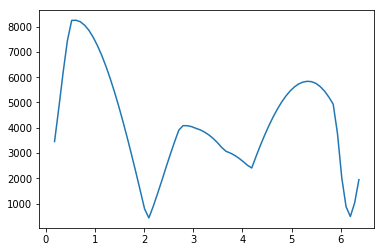

In [220]:
plot([t for t, l in res], [l for t, l in res])

In [232]:
show_1d_travel(
    direction=p,
    labels = torch.Tensor(y_train_tree[:10]), 
    observations = torch.Tensor(X_train_tree[:10]),
    scale=1)

[========================================================================] 100%


### Tests - comparing fglib chain to my chain 

In [90]:
def _phi(x, y):
    return np.array([[0, 0], [0, 0]])[x, y]

def _psi(yi, yj):
    return np.array([[0, 0], [0, 0]])[yi, yj]

In [91]:
chain = Chain(length=10, phi=phi, psi=psi, possible_values=[0, 1])

In [92]:
observation = [1, 0, 1, 0, 1, 1, 0, 0, 0, 1]

In [93]:
chain.update_observed(observation)

In [163]:
%%time
chain._get_beliefs(method='max_product')

CPU times: user 7.04 ms, sys: 380 µs, total: 7.42 ms
Wall time: 7.07 ms


{1: [0.38941740089180304, 0.6105825991081971],
 2: [0.190131286853423, 0.8098687131465769],
 3: [0.07954443968454424, 0.9204555603154557],
 4: [0.06615232309062243, 0.9338476769093775],
 5: [0.15444976602895394, 0.845550233971046],
 6: [0.09996697945642491, 0.900033020543575],
 7: [0.11932991109743654, 0.8806700889025635],
 8: [0.26906028368794327, 0.7309397163120568],
 9: [0.6231326307208381, 0.37686736927916187],
 10: [0.6231326307208381, 0.3768673692791618],
 11: [0.6231326307208381, 0.3768673692791618],
 12: [0.623132630720838, 0.37686736927916187],
 13: [0.6231326307208381, 0.37686736927916187],
 14: [0.6231326307208381, 0.3768673692791619],
 15: [0.26906028368794327, 0.7309397163120568],
 16: [0.1828930580792228, 0.8171069419207772],
 17: [0.1828930580792228, 0.8171069419207772],
 18: [0.26906028368794327, 0.7309397163120567],
 19: [0.6901017576318225, 0.3098982423681776],
 20: [0.7691626686225155, 0.2308373313774846],
 21: [0.7691626686225154, 0.23083733137748458],
 22: [0.76916

In [102]:
fg, y_nodes = create_tree(observation, T=10, chain=True)

In [103]:
_, track = inference.max_sum(fg, query_node=None)

In [104]:
# Print belief of variables
print("Belief of variable node:", [y_.belief(fg.get_incoming_messages(y_), normalize=False, logarithmic=True).pmf for y_ in y_nodes])
print("Argmax of variable node:", [track[_y] for _y in y_nodes])

Belief of variable node: [array([5.15584487, 6.29549936]), array([5.15584487, 6.29549936]), array([5.15584487, 6.29549936]), array([5.15584487, 6.29549936]), array([5.15584487, 6.29549936]), array([5.30042775, 6.29549936]), array([6.29549936, 6.13493448]), array([6.29549936, 6.13493448]), array([6.29549936, 6.13493448]), array([6.29549936, 6.13493448])]
Argmax of variable node: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [105]:
model = ChainTorch(length=10)

In [106]:
j = [2.5]
b = [-0.8, 1.]

j = torch.Tensor(j) 
b = torch.Tensor(b)

observations = torch.Tensor([observation])

beliefs = model(j, b, observations)
beliefs

tensor([[[5.1250, 5.1250, 5.1250, 5.1250, 5.1250, 5.2750, 6.2750, 6.2750,
          6.2750, 6.2750],
         [6.2750, 6.2750, 6.2750, 6.2750, 6.2750, 6.2750, 6.1250, 6.1250,
          6.1250, 6.1250]]])

In [100]:
(beliefs[:, 1, :] > beliefs[:, 0, :]).float()

tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0.]])

In [128]:
#observations = torch.Tensor(X_train[:10])
observations.shape

torch.Size([1, 10])

#####  compare the creation of labels

In [213]:
from _chain import Chain, f_phi, f_psi
from _chain_torch import Chain as ChainTorch

In [212]:
T = 50

In [8]:
phi = f_phi(b=[-0.8, 1])
psi = f_psi(j=2.5)

In [10]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

In [ ]:
model = ChainTorch(length=T)

In [211]:
for i in range(10):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y_my_chain = chain.get_max_apostriori_beliefs()

    fg, y_nodes = create_tree(x_binary, T=T, chain=True)
    _, track = inference.max_sum(fg)
    
    y_fglib = [track[_y].item() for _y in y_nodes]
    
    j = [2.5]
    b = [-0.8, 1.]
    j = torch.Tensor(j) 
    b = torch.Tensor(b)
    observations = torch.Tensor([x_binary])
    beliefs = model(j, b, observations)
    y_torch = (beliefs[:, 1, :] > beliefs[:, 0, :])
    
    if not all(np.equal(y_fglib, y_torch.numpy())):
        print(y_my_chain[-10:], y_fglib[-10:], y_torch.numpy()[0, -10:])

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0] [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] [1 1 1 1 0 0 0 0 0 0]


In [183]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    fg, y_nodes = create_tree(x_binary, T=T, chain=True)
    _, track = inference.max_sum(fg)
    
    y = [track[_y].item() for _y in y_nodes]

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 25.2 s, sys: 148 ms, total: 25.3 s
Wall time: 25.4 s


In [184]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

In [209]:
_, track = inference.max_sum(fg, query_node=y_nodes[1])
[(str(k), v.item()) for k, v in track.items() if k in y_nodes]

[('y1', 0),
 ('y0', 0),
 ('y2', 0),
 ('y3', 0),
 ('y4', 0),
 ('y5', 0),
 ('y6', 0),
 ('y7', 0),
 ('y8', 0),
 ('y9', 0),
 ('y10', 0),
 ('y11', 0),
 ('y12', 1),
 ('y13', 1),
 ('y14', 1),
 ('y15', 1),
 ('y16', 1),
 ('y17', 1),
 ('y18', 1),
 ('y19', 1),
 ('y20', 1),
 ('y21', 1),
 ('y22', 0),
 ('y23', 0),
 ('y24', 0),
 ('y25', 0),
 ('y26', 0),
 ('y27', 0),
 ('y28', 0),
 ('y29', 0),
 ('y30', 1),
 ('y31', 1),
 ('y32', 1),
 ('y33', 1),
 ('y34', 1),
 ('y35', 1),
 ('y36', 1),
 ('y37', 1),
 ('y38', 1),
 ('y39', 1),
 ('y40', 1),
 ('y41', 0),
 ('y42', 0),
 ('y43', 0),
 ('y44', 0),
 ('y45', 0),
 ('y46', 0),
 ('y47', 0),
 ('y48', 0),
 ('y49', 0)]